## **II. Analysis**

*(approx. 2-4 pages)*

### **Data Exploration**

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:

* *If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?*

* *If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?*

* *If a dataset is not present for this problem, has discussion been made about the input space or input data for your problem?*

* *Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)*


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    nuclei_files = np.array(glob(path+'/*/images/*'))
    nuclei_targets = np.array(glob(path+'/*/masks/*'))
    return nuclei_files,nuclei_targets

train_files,train_targets = load_dataset('stage1_train/')
test_files,test_targets= load_dataset('stage1_test/')

#TODO: pick a better represntation of a validation set

print('There are %d training batch nuecli images.' % len(train_files))
print('There are %d training batch nuecli masks.' % len(train_targets))




Using TensorFlow backend.
D:\Kareem\Conda\envs\dog-project\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


There are 670 training batch nuecli images.
There are 29461 training batch nuecli masks.


In [2]:
# Binding masks with the parent image:
import os.path

def get_filename(path):
    return os.path.splitext(os.path.basename(path))[0]

def bind_mask_to_images(images_paths, masks_paths):
    image_id = 0
    filename = get_filename(images_paths[0])
    masks_binded = [[]]
    for mask_path in masks_paths:
        if filename in mask_path:
            masks_binded[image_id].append(mask_path)
        else:
            image_id = image_id+1
            filename = get_filename(images_paths[image_id])
            masks_binded.append([mask_path])
    return np.array(masks_binded)

    
train_targets_binded = bind_mask_to_images(train_files,train_targets)
#train_targets_merged = merge_masks(train_targets_binded)

print("Train targets have been binded")

Train targets have been binded


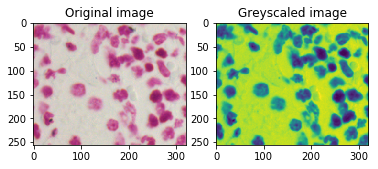

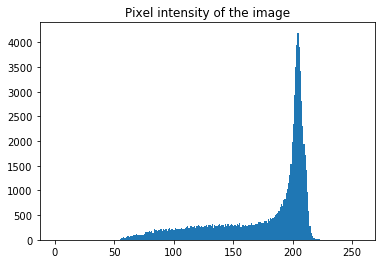

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# load color (BGR) image
img = cv2.imread(train_files[3])
# convert BGR image to grayscale
gray = cv2.imread(train_files[3],0)


#from skimage.color import rgb2gray
#im_gray = rgb2gray(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(1,2,2)
plt.title("Greyscaled image")
plt.imshow(gray)
plt.show()
#pixel intensity for image
plt.hist(gray.ravel(),256,[0,256])
plt.title("Pixel intensity of the image")
plt.show()


### Sources:
- https://docs.opencv.org/3.1.0/d1/db7/tutorial_py_histogram_begins.html 
- https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/ 
- dog-project

In [36]:
from sklearn.cluster import KMeans
import random

seed = random.seed(8675309)
def find_dominant_color_in_image(image,number_of_clusters):
    # re-shape our image to be a list of pixels, rather than MxN matrix of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    color_clf = KMeans(random_state=seed,n_clusters = number_of_clusters)
    color_clf.fit(image)
    
    return color_clf.cluster_centers_

def cluster_images_based_on_color(images_path_array,number_of_clusters,number_of_colors):
    dominant_colors = []
    for image_path in images_path_array:
        image = cv2.imread(image_path)
        colors_in_image = find_dominant_color_in_image(image,number_of_colors)
        dominant_colors.append(colors_in_image.flatten())
    #print(image)
    #print(dominant_colors)
    img_clf = KMeans(random_state=seed,n_clusters = number_of_clusters)
    img_clf.fit(np.array(dominant_colors))
    return img_clf

def plot_color_bar(colors):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for color in colors:
        #print ("color in bar",color)
        endX = startX + (1/len(colors) * 300)
        #print("the start is",startX, 'the end is',endX)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),color.astype("uint8").tolist(), -1)
        startX = endX
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    return bar





In [5]:
number_of_colors = 3
images_clf = cluster_images_based_on_color(train_files,3,number_of_colors)


670


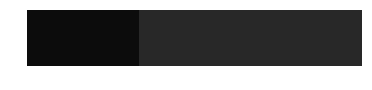

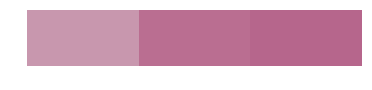

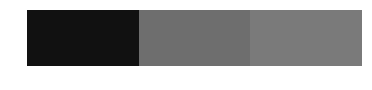

In [6]:
colors_clusters = images_clf.cluster_centers_
labels = images_clf.labels_
print(len(labels))
RGB_COLORS_CONSTANT = 3
if(number_of_colors>1):
    for color in colors_clusters:
        plot_color_bar(np.split(color,RGB_COLORS_CONSTANT))
else:
    for color in colors_clusters:
        plot_color_bar(color)

## Colors and Stains:

We can observe from the previous clusters that the dataset is stained differently, the differences in coloring. Hence, we'll be using grayscale?

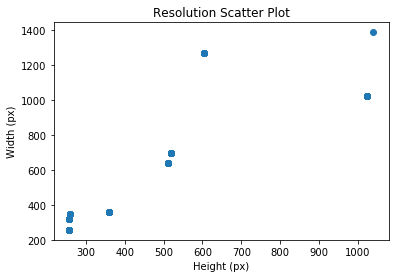

In [7]:
#print (images_clf)
sample_image = cv2.imread(train_files[0])
#print (sample_image.shape[1])
def get_images_features_list(images_path_array):
    images_height = []
    images_width = []
    images_mean = []
    images_std= []
    for image_path in images_path_array:
        image = cv2.imread(image_path)
        images_height.append(image.shape[0])
        images_width.append(image.shape[1])
        images_mean.append(np.mean(image))
        images_std.append(np.std(image))
    return images_height,images_width,images_mean,images_std

def plot_scatter_plot(X,y):
    plt.xlabel("Height (px)")
    plt.ylabel("Width (px)")
    plt.title("Resolution Scatter Plot")
    plt.scatter(X, y)
    
X,y,means,stdvs = get_images_features_list(train_files)
plot_scatter_plot(X,y)

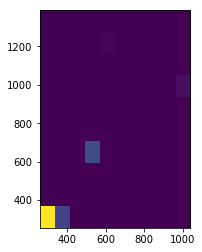

In [8]:
heatmap, xedges, yedges = np.histogram2d(X, y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

paired = (list(zip(X,y)))



In [33]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=paired)
#print(df.keys)
df.index.name = 'x label'

ax = df.plot.hexbin(x=0, y=1, gridsize=5,title="Resolution Heatmap",)
ax.set_ylabel("Width (px)")
ax.set_xlabel("Height (px)") #bug in juypter notebook doens't show the x-axis


NameError: name 'paired' is not defined

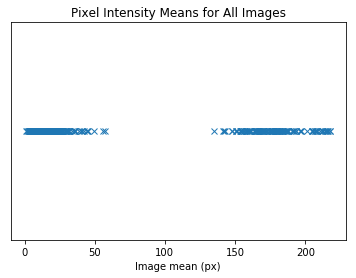

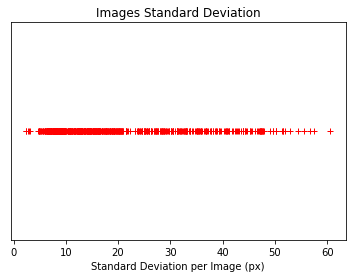

In [10]:
#Plot "Pixel Intensity Means for All Images" and "Standard Deviation per Image"

plt.plot(means, np.zeros_like(means), 'x')
plt.xlabel("Image mean (px)")
plt.title("Pixel Intensity Means for All Images")
plt.axes().get_yaxis().set_visible(False)
plt.show()
plt.plot(stdvs, np.zeros_like(stdvs), 'r+')
plt.title("Images Standard Deviation")
plt.axes().get_yaxis().set_visible(False)
plt.xlabel("Standard Deviation per Image (px)")
plt.show()

## Preprocessing:

In [4]:
#Taken from dog-project, Preprocessing for Keras
from keras.preprocessing import image as KImage                  
from tqdm import tqdm
from PIL import ImageFile                            
from skimage import io, img_as_float
from skimage.transform import resize
from skimage.color import rgb2gray,rgba2rgb

img_height, img_width = 224,224

#Doesn't work shows target fully black.
def old_path_to_image(img_path):
    # loads RGB image as PIL.Image.Image type
    img = KImage.load_img(img_path, target_size=(img_height, img_width))
    # convert PIL.Image.Image type to 3D tensor with shape (150, 150, 3)
    image_array = KImage.img_to_array(img)
    return image_array

def path_to_image(img_path):
    image = io.imread(img_path)
    #transform image to  height and width to match model requirements
    image = resize(image, (img_height, img_width), mode='constant')
    #rgba to rgb
    try:
        image = rgba2rgb(image)
    except:
        if(len(image.shape)<3):
            image = np.expand_dims(image,axis=-1)
    image = img_as_float(image)
    return image

def path_to_tensor(img_path):
    x = path_to_image(img_path)
    return image_to_tensor(x)

def image_to_tensor(img):
    # convert 3D tensor to 4D tensor with shape (1, 150, 150, 3) and return 4D tensor
    return np.expand_dims(img, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    #print(list_of_tensors[0])
    return np.vstack(list_of_tensors)

def images_to_tensor(img_list):
    list_of_tensors = [image_to_tensor(img_list) for img_list in tqdm(img_list)]
    #print(list_of_tensors[0])
    return np.vstack(list_of_tensors)


In [5]:
def merge_masks(train_targets_binded):
    bigboy = []
    for binder in (train_targets_binded):
        merged_mask = np.zeros_like(path_to_image(binder[0]))##.astype('float32')/255 ?
        for mask_path in binder:
            mask = path_to_image(mask_path)
            merged_mask = np.maximum(merged_mask,mask)
        binder = merged_mask
        bigboy.append(merged_mask)
    return bigboy

In [6]:
#ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras, since we need to match the pre-trained enviroment
train_files_tensors = paths_to_tensor(train_files)

train_targets_merged = merge_masks(train_targets_binded)
#print(train_targets_merged[0])
train_target_tensors = images_to_tensor(train_targets_merged)

print(train_files.shape)
print(train_targets_binded.shape)
#print(train_targets_merged.shape)
print(train_files_tensors.shape)
print(train_target_tensors.shape)




100%|█████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 668136.87it/s]


(670,)
(670,)
(670, 224, 224, 3)
(670, 224, 224, 1)


### Sanity Check:

(224, 224, 3)


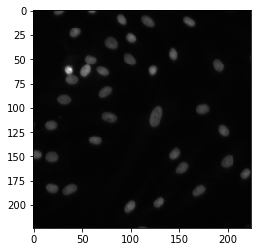

(224, 224, 1)


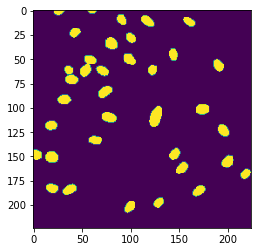

(224, 224, 3)


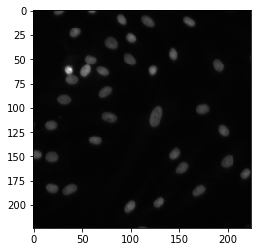

In [7]:
def plot_image(img):
    print(img.shape)
    plt.imshow(np.squeeze(img))
    #print(img)
    plt.show()
    
plot_image(train_files_tensors[1])
plot_image(train_target_tensors[1])
s = path_to_image(train_files[1])
#s = np.expand_dims(train_files_tensors[1], axis=-1)
plot_image(s)
#print(range(train_files_tensors.shape[:1][0]-1))


### Model:

In [8]:
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv2DTranspose
from keras.layers import Dropout, Flatten, Dense, Reshape
from keras.models import Sequential,Model

#TODO bottleneck_features
base_model = Xception(input_shape=train_files_tensors.shape[1:],weights='imagenet', include_top=False)

xc = base_model.output
output= Conv2DTranspose(3, (3, 3), strides=(30, 30), padding='same',activation='relu')(xc)

Xception_starter_model = Model(base_model.input, output)

for layer in Xception_starter_model.layers[:132]:
    layer.trainable = False

print(Xception_starter_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

In [9]:
xc = base_model.output

ct1 = Conv2DTranspose(729, (2, 2), strides=(2, 2), padding='same',activation='relu')(xc)
c6 = Conv2D(729, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(ct1)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(729, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)
ct2 = Conv2DTranspose(81, (2, 2), strides=(3, 3), padding='same',activation='relu')(c6)
c7 = Conv2D(81, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(ct2)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(81, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)
output = Conv2DTranspose(1, (2, 2), strides=(5, 5), padding='same',activation='relu')(c7)

Xception_intermid_model = Model(base_model.input, output)

# freeze Xception layers
for layer in Xception_intermid_model.layers[:132]:
    layer.trainable = False

print(Xception_intermid_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

### Metric:

In [10]:
#Taken from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277#295658

def meanIoU(y_true_batch, y_pred_batch):
    return np.mean(np.asarray([IoU(y_pred_batch, y_true_batch,t) for t in np.arange(0.5, 1, 0.05)])) 

def IoU(y_pred_batch, y_true_batch, threshold):
    pxArray = []
    for i in range(100):
        print(i)
        px = pixelAccuracy(y_pred_batch[i], y_true_batch[i],threshold)
        pxArray.append(px)
    
    return pxArray

def pixelAccuracy(y_pred_orig, y_true, threshold):
    print(y_pred_orig, y_true, threshold)
    y_pred = wrap_booleans(y_pred_orig > threshold)
    #true positive / (true positive + false positive + false negative)
    
    return 1.0 * np.sum(wrap_booleans(y_pred==y_true)*wrap_booleans(y_true>0)) /  (np.sum(wrap_booleans(y_pred>0)) + np.sum(wrap_booleans(y_true>0)) - np.sum(wrap_booleans(y_pred==y_true))*wrap_booleans(y_true>0))

def wrap_booleans (exp):
    if exp: return 1
    else: return 0

In [11]:
# Metric function, taken from https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/Data_Science_Bowl_2018.ipynb
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Compile:

In [12]:
Xception_intermid_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=[dice_coef,meanIoU])


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
0
Tensor("strided_slice:0", shape=(?, ?, 1), dtype=float32) Tensor("strided_slice_1:0", shape=(?, ?, ?), dtype=float32) 0.5


TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [ ]:
#print(train_files_tensors[9])

In [13]:
# taken from dog-project
from keras.callbacks import ModelCheckpoint,EarlyStopping

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception_interim.hdf5', 
                               verbose=1, save_best_only=True)

Xception_intermid_model.fit(train_files_tensors, train_target_tensors, validation_split=0.1,
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)



ValueError: Error when checking model target: expected conv2d_transpose_4 to have shape (None, 210, 210, 1) but got array with shape (670, 224, 224, 1)

In [14]:
def detect_nuclei(predictor,img_path):
    # obtain predicted vector
    predicted_vector = predictor.predict(path_to_tensor(img_path))
    # return dog breed that is predicted by the model
    return predicted_vector


(224, 224, 3)


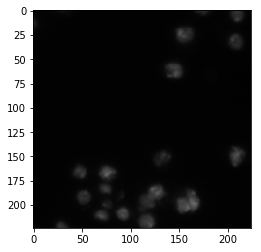

(224, 224, 1)


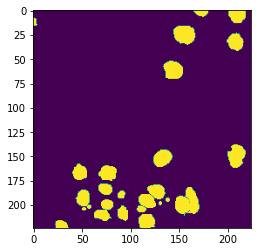

(210, 210, 1)


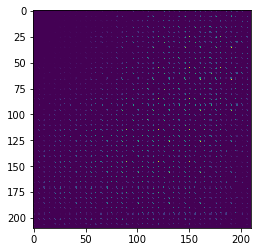

In [15]:
## Sanity Check:
predImage = detect_nuclei(Xception_intermid_model,train_files[0])
plot_image(path_to_image(train_files[0]))
plot_image(train_targets_merged[0])
plot_image(predImage[0])



In [16]:
#Taken from https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model
from zf_unet_224_model import ZF_UNET_224, dice_coef_loss
from keras.optimizers import Adam

zf_unet_starter = ZF_UNET_224()
zf_unet_starter.load_weights("saved_models/zf_unet_224.h5") # optional
optim = Adam()
zf_unet_starter.summary()
zf_unet_starter.compile(optimizer=optim , loss=[dice_coef_loss], metrics=[dice_coef])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 32)      0         
__________

In [17]:
#Scored 0.290 with 100epochs without earlystopping and with cutoff labeling postprocess, dice as a measure
from keras.callbacks import EarlyStopping
epochs = 50

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.zfunet_starter.hdf5', 
                               verbose=1, save_best_only=True)

zf_unet_starter.fit(train_files_tensors, train_target_tensors, validation_split=0.1,
          epochs=epochs, batch_size=20, callbacks=[earlystopper,checkpointer], verbose=1)

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 28s - loss: -0.6561 - dice_coef: 0.6561 - val_loss: -2.7642e-04 - val_dice_coef: 2.7642e-04
Epoch 2/50
603/603 [==============================] - 17s - loss: -0.8149 - dice_coef: 0.8149 - val_loss: -9.7971e-06 - val_dice_coef: 9.7971e-06
Epoch 3/50
603/603 [==============================] - 19s - loss: -0.8511 - dice_coef: 0.8511 - val_loss: -0.0059 - val_dice_coef: 0.0059
Epoch 4/50
603/603 [==============================] - 19s - loss: -0.8078 - dice_coef: 0.8078 - val_loss: -0.0634 - val_dice_coef: 0.0634
Epoch 5/50
603/603 [==============================] - 19s - loss: -0.8641 - dice_coef: 0.8641 - val_loss: -0.0968 - val_dice_coef: 0.0968
Epoch 6/50
603/603 

(224, 224, 3)


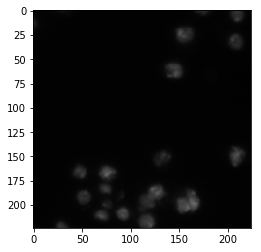

(224, 224, 1)


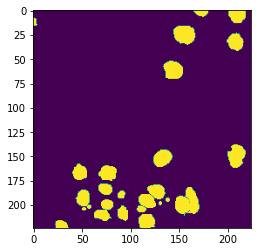

(224, 224, 1)


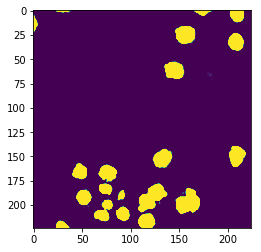

In [18]:
#Sanity Check:
predImage = detect_nuclei(zf_unet_starter,train_files[0])
plot_image(path_to_image(train_files[0]))
plot_image(train_targets_merged[0])
plot_image(predImage[0])

In [19]:
from keras.layers import Activation

base_model = ZF_UNET_224()
base_model.load_weights("saved_models/zf_unet_224.h5") # optional

#zf_unet_intermid = Model(inputs=base_model.input, outputs=top_model(base_model.output))
zf_unet_intermid = base_model

#slow leraning rate by a factor of 10
optim = Adam(lr=0.001/10)
zf_unet_intermid.summary()
zf_unet_intermid.compile(optimizer=optim , loss=[dice_coef_loss], metrics=[dice_coef])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_27 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_24 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_28 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_25 (Activation)   (None, 224, 224, 32)      0         
__________

In [20]:
epochs = 50

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.zfunet_intermid.hdf5', 
                               verbose=1, save_best_only=True)

zf_unet_intermid.fit(train_files_tensors, train_target_tensors, validation_split=0.1,
          epochs=epochs, batch_size=20, callbacks=[earlystopper,checkpointer], verbose=1)

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 25s - loss: -0.6717 - dice_coef: 0.6717 - val_loss: -0.0075 - val_dice_coef: 0.0075
Epoch 2/50
603/603 [==============================] - 19s - loss: -0.8124 - dice_coef: 0.8124 - val_loss: -0.1710 - val_dice_coef: 0.1710
Epoch 3/50
603/603 [==============================] - 19s - loss: -0.8427 - dice_coef: 0.8427 - val_loss: -0.2056 - val_dice_coef: 0.2056
Epoch 4/50
603/603 [==============================] - 19s - loss: -0.8581 - dice_coef: 0.8581 - val_loss: -0.6075 - val_dice_coef: 0.6075
Epoch 5/50
603/603 [==============================] - 17s - loss: -0.8436 - dice_coef: 0.8436 - val_loss: -0.5167 - val_dice_coef: 0.5167
Epoch 6/50
603/603 [===============

In [26]:
#Read Test Data:
def load_testset(path):
    nuclei_files = np.array(glob(path+'/*/images/*'))
    return nuclei_files

def get_image_resolution(img_path):
    image = io.imread(img_path)
    return image.shape[:2]

def get_img_list_dims(test_files):
    dims_tuples = []
    for path in test_files:
        dims_tuples.append(get_image_resolution(path))
    return dims_tuples

def resize_image(image_as_array, desired_size_tuple):
    image_resized = np.squeeze(resize(image_as_array, desired_size_tuple, mode='constant'))
    #plot_image(image_resized)
    return image_resized


def get_predections(test_dataset_paths,predection_model):
    original_dims = get_img_list_dims(test_dataset_paths)
    test_predections_rescaled = []
    print("Predicting test images")
    for i,img_path in enumerate(tqdm(test_dataset_paths)):
        tensor = predection_model.predict(path_to_tensor(img_path))
        image = tensor[0]
        resized_image = resize_image(image,original_dims[i])
        #print(resized_image.shape)
        test_predections_rescaled.append(resized_image)
    print("Finished perdicting test images")
    return test_predections_rescaled


In [27]:
TEST_PATH='stage1_test/'           
test_files = load_dataset(TEST_PATH)[0]
predection_images_resized = get_predections(test_files,zf_unet_intermid)


Predicting test images


100%|███████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 19.65it/s]


Finished perdicting test images


In [28]:
#TODO fix IOU
#Inspired from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277#295658 and https://www.kaggle.com/wcukierski/example-metric-implementation


def meanIoU(y_true_batch, y_pred_batch):
    return np.mean(np.asarray([IoU(y_pred_batch, y_true_batch,thresholds) for thresholds in np.arange(0.5, 1, 0.05)])) 

def IoU(y_pred_batch, y_true_batch, threshold):
    pxArray = []
    for i in range(y_true_batch):
        print(i)
        px = pixelAccuracy(y_pred_batch[i], y_true_batch[i],threshold)
        pxArray.append(px)
    
    return pxArray

# http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_join_segmentations.html
def pixelAccuracy(y_pred_orig, y_true, threshold):
    print(y_pred_orig, y_true, threshold)
    y_pred = wrap_booleans(y_pred_orig > threshold)
    #true positive / (true positive + false positive + false negative)
    tp/tp+fp+fn
    return np.sum(wrap_booleans()*wrap_booleans(y_true>0)) /  (np.sum(wrap_booleans(y_pred>0)) + np.sum(wrap_booleans(y_true>0)) - np.sum(wrap_booleans(y_pred==y_true))*wrap_booleans(y_true>0))

def wrap_booleans (exp):
    if exp: return 1
    else: return 0

In [29]:
#TODO RLE
from skimage.morphology import label
from skimage.segmentation import watershed, random_walker
from scipy import ndimage
from skimage.feature import peak_local_max

# Run-length encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

#Taken from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855
def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    #print(lab_img)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

#Experminations with watershed and random walker 
#Source: (http://www.scipy-lectures.org/packages/scikit-image/auto_examples/plot_segmentations.html)
def label_rw_to_rles(image):
    distance = ndimage.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
    markers = label(local_maxi)
    markers[~image] = -1 #TODO fix
    labels_rw = random_walker(image, markers)
    for i in range(1, labels_rw.max() + 1):
        yield rle_encoding(labels_rw == i)
    
def label_ws_to_rles(image):
    distance = ndimage.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
    markers = label(local_maxi)
    labels_ws = watershed(-distance, markers, mask=image)
    for i in range(1, labels_ws.max() + 1):
        yield rle_encoding(labels_ws == i)
    

In [30]:
#Taken from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855

test_ids = next(os.walk(TEST_PATH))[1]
new_test_ids = []
rles = []
#print(predection_images_resized)
for n, id_ in enumerate(tqdm(test_ids)):
    rle = list(prob_to_rles(predection_images_resized[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

#print(rles)


100%|███████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 50.02it/s]


In [34]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

44


D:\Kareem\Conda\envs\dog-project\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


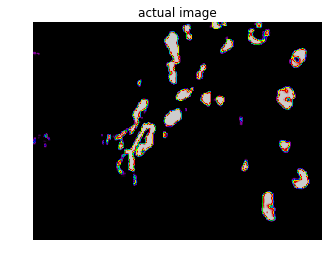

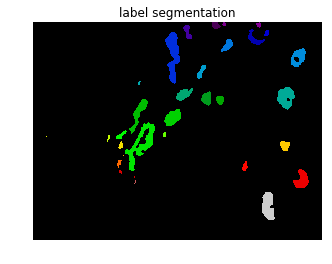

IndexError: index -1 is out of bounds for axis 0 with size 0

In [43]:
#Experminations with ws 

rn = random.randint(0, len(predection_images_resized))
print(rn)
pred_image = predection_images_resized[rn]

plt.imshow(pred_image, cmap='spectral', interpolation='nearest')
plt.axis('off')
plt.title('actual image')
plt.show()


lab_img = label(pred_image >0.5)
plt.imshow(lab_img, cmap='spectral', interpolation='nearest')
plt.axis('off')
plt.title('label segmentation')
plt.show()



distance = ndimage.distance_transform_edt(pred_image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=pred_image)
markers = label(local_maxi)
labels_ws = watershed(-distance, markers, mask=pred_image)


plt.imshow(labels_ws, cmap='spectral', interpolation='nearest')
plt.axis('off')
plt.title('watershed segmentation')
plt.show()


In [ ]:
#Double U-Net? Freeze, Xception as Encoder Reverse Xception as Decoder